In [1]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 32
max_length = 128
num_epochs = 20
learning_rate = 3e-4

Using device: cuda


In [3]:
df = pd.read_csv("../Final_Dataset_Fixed.csv")



In [4]:
df = df[df['category'] == 'poems']
df.head()

,text,label,category
18000,"আমি হেথায় থাকি শুধু\r\nগাইতে তোমার গান,\r\nদিয়...",human,poems
18001,বিশ্বধরণীর এই বিপুল কুলায়\r\nসন্ধ্যা-- তারি ন...,human,poems
18002,কোথাও নদীর পারে সময়ের বুকে-\r\nদাঁড়ায়ে রয়েছে আ...,human,poems
18003,আবার ফিরে এল বাইশে শ্রাবণ।\r\nআজ বর্ষশেষে হে অ...,human,poems
18004,শস্যের ভিতরে রৌদ্রে পৃথিবীর সকালবেলায়\r\nকোনো ...,human,poems


In [5]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import re
from tokenizers import ByteLevelBPETokenizer
from transformers import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
max_length = 128
d_model = 512
nhead = 8
num_layers = 6
dim_feedforward = 2048
num_classes = 2  # Binary classification: human vs. AI
batch_size = 16
learning_rate = 2e-5
num_epochs = 20  # Updated to 20 epochs
warmup_steps = 500

# Custom Transformer Model
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)

# Load and preprocess dataset
df = pd.read_csv("../Final_Dataset_Fixed.csv")

# Filter for "poems" category
df = df[df['category'] == 'poems']

# Drop rows with missing labels or text
df = df.dropna(subset=['text', 'label'])

# Map labels to binary (human: 1, AI: 0)
df['is_human'] = df['label'].map({'human': 1, 'ai': 0})

# Drop rows where mapping failed (i.e., unknown labels)
df = df.dropna(subset=['is_human'])

texts = df['text'].tolist()
labels = df['is_human'].astype(int).tolist()

# Basic text preprocessing for Bengali
def preprocess_text(text):
    # Remove special characters, keep Bengali characters and spaces
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep Bengali Unicode range
    text = text.strip()
    return text

texts = [preprocess_text(text) for text in texts]

# Split the data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Train or load tokenizer
if not os.path.exists("bengali_tokenizer_poems"):
    os.makedirs("bengali_tokenizer_poems")
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
    tokenizer.save_model("bengali_tokenizer_poems")
else:
    tokenizer = ByteLevelBPETokenizer("bengali_tokenizer_poems/vocab.json", "bengali_tokenizer_poems/merges.txt")

# Encode texts
def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else [1] * max_length
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids, dtype=torch.long), torch.tensor(attention_masks, dtype=torch.long)

# Dataset class
class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attention_mask = encode_batch(texts)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# Create datasets and dataloaders
train_dataset = BengaliTextDataset(train_texts, train_labels)
val_dataset = BengaliTextDataset(val_texts, val_labels)
test_dataset = BengaliTextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Plot dataset distribution
def plot_dataset_distribution():
    label_counts = pd.Series(labels).value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='viridis', legend=False)
    plt.title('Dataset Class Distribution')
    plt.xlabel('Class (0: AI, 1: Human)')
    plt.ylabel('Count')
    plt.savefig('dataset_distribution.png')
    plt.close()

plot_dataset_distribution()

# Initialize model
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size, max_len=max_length, d_model=d_model, nhead=nhead,
                         num_layers=num_layers, dim_feedforward=dim_feedforward, num_classes=num_classes).to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
total_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

# Training loop with metrics tracking
model.train()
history = defaultdict(list)

for epoch in range(num_epochs):
    total_loss = 0
    train_preds, train_true = [], []
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        train_preds.extend(preds)
        train_true.extend(labels.cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = accuracy_score(train_true, train_preds)
    history['train_loss'].append(avg_train_loss)
    history['train_accuracy'].append(train_accuracy)

    # Validation
    model.eval()
    val_preds, val_true = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_true, val_preds)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print("Validation Classification Report:")
    print(classification_report(val_true, val_preds, target_names=['AI', 'Human'], zero_division=0))
    model.train()

# Plot training and validation metrics
def plot_metrics(history):
    epochs = range(1, num_epochs + 1)
    
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics_poems.png')
    plt.close()

plot_metrics(history)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix_poems.png')
    plt.close()

plot_confusion_matrix(val_true, val_preds)

# Final evaluation on test set
model.eval()
test_preds, test_true = [], []
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(test_true, test_preds, target_names=['AI', 'Human'], zero_division=0))

# Plot test confusion matrix
plot_confusion_matrix(test_true, test_preds)

c:\Users\Jim\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/20
Train Loss: 0.5831, Train Accuracy: 0.6977
Val Loss: 0.2226, Val Accuracy: 0.9917
Validation Classification Report:
              precision    recall  f1-score   support

          AI       0.98      1.00      0.99       300
       Human       1.00      0.98      0.99       300

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

Epoch 2/20
Train Loss: 0.2183, Train Accuracy: 0.9942
Val Loss: 0.2012, Val Accuracy: 1.0000
Validation Classification Report:
              precision    recall  f1-score   support

          AI       1.00      1.00      1.00       300
       Human       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Epoch 3/20
Train Loss: 0.2131, Train Accuracy: 0.9956
Val Loss: 0.1998, Val Accuracy: 1.0000

In [6]:
# Save final model and tokenizer
final_model_path = 'poems_model.pt'
torch.save({
    'poems_model_state_dict': model.state_dict(),
    'poems_model_optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
}, final_model_path)
print(f"Final model saved to {final_model_path}")

# Save the entire model (including architecture)
full_model_path = 'poems_model.pth'
torch.save(model, full_model_path)
print(f"Full model saved to {full_model_path}")

Final model saved to poems_model.pt
Full model saved to poems_model.pth


In [7]:
# Load best/final model state
checkpoint = torch.load('poems_model.pt')  # or 'final_model.pt'
model.load_state_dict(checkpoint['poems_model_state_dict'])
optimizer.load_state_dict(checkpoint['poems_model_optimizer_state_dict'])

# Load full model
model = torch.load('poems_model.pth', weights_only=False)

# Load tokenizer
tokenizer = ByteLevelBPETokenizer("bengali_tokenizer_poems/vocab.json", "bengali_tokenizer_poems/merges.txt")

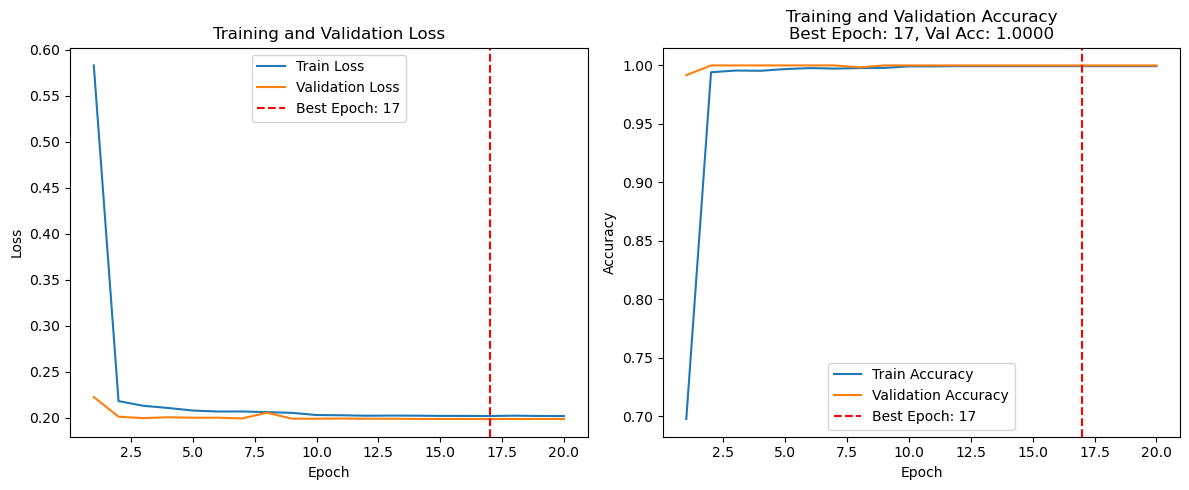

Best Epoch: 17, Validation Accuracy: 1.0000


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    best_epoch = np.argmin(history['val_loss']) + 1
    best_val_accuracy = history['val_accuracy'][best_epoch - 1]
    
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch}')
    plt.title(f'Training and Validation Accuracy\nBest Epoch: {best_epoch}, Val Acc: {best_val_accuracy:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics_poems.png')
    plt.show()
    
    print(f"Best Epoch: {best_epoch}, Validation Accuracy: {best_val_accuracy:.4f}")

plot_metrics(history)

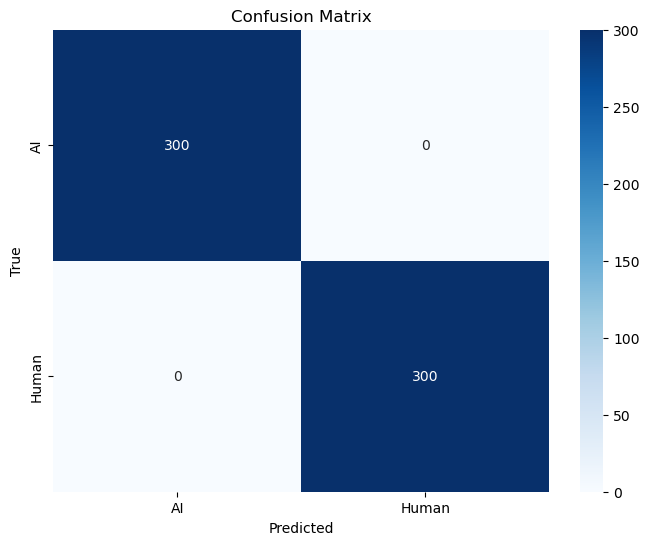

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

plot_confusion_matrix(val_true, val_preds, title='Confusion Matrix')

In [11]:
import torch
from tokenizers import ByteLevelBPETokenizer
import re

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = ByteLevelBPETokenizer("bengali_tokenizer_poems/vocab.json", "bengali_tokenizer_poems/merges.txt")

# Load the full model
model = torch.load('poems_model.pth', weights_only=False)
model.to(device)
model.eval()

# Hyperparameters (must match training)
max_length = 128

# Basic text preprocessing for Bengali
def preprocess_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep Bengali Unicode range
    text = text.strip()
    return text

# Encode texts
def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else [1] * max_length
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids, dtype=torch.long), torch.tensor(attention_masks, dtype=torch.long)

# Sample texts (replace with your own Bengali texts)
sample_texts = [
    "একটি ছোট গল্প যা মানুষের হৃদয় ছুঁয়ে যায়।",  # Human-like
    "এই গল্পটি স্বয়ংক্রিয়ভাবে উৎপন্ন হয়েছে এবং এতে কৃত্রিম বুদ্ধিমত্তার স্বাদ রয়েছে।"  # AI-like
]

# Preprocess and encode sample texts
sample_texts = [preprocess_text(text) for text in sample_texts]
input_ids, attention_mask = encode_batch(sample_texts)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

# Map predictions to labels
label_map = {0: "AI", 1: "Human"}
for text, pred in zip(sample_texts, predictions):
    print(f"Text: {text}")
    print(f"Predicted: {label_map[pred]}\n")

Text: একটি ছোট গল্প যা মানুষের হৃদয় ছুঁয়ে যায়
Predicted: AI

Text: এই গল্পটি স্বয়ংক্রিয়ভাবে উৎপন্ন হয়েছে এবং এতে কৃত্রিম বুদ্ধিমত্তার স্বাদ রয়েছে
Predicted: Human

